<a href="https://colab.research.google.com/github/2pterons/multicampus/blob/main/20210918_KoGPT2_idiom_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **⦁ GPT** 구조

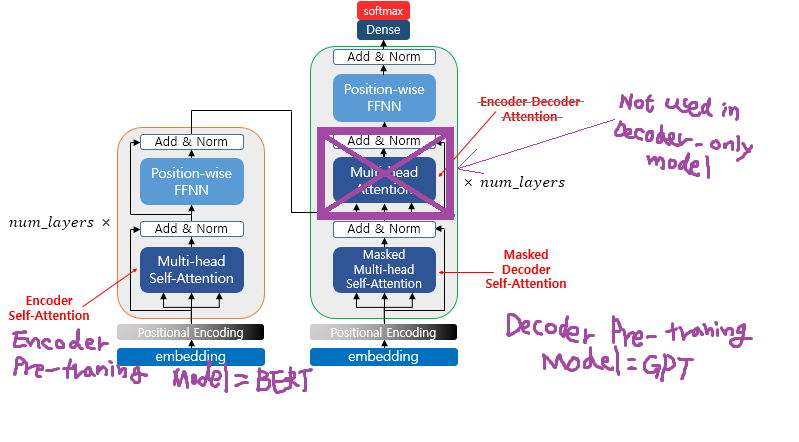

<br/><br/>

# **KoGPT2를 이용한 감성분석**
<br/>


### 1. 라이브러리 설치 및 임포트

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data/

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


In [ ]:
!pip install --upgrade mxnet>=1.6.0
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer, SentencepieceDetokenizer
from transformers import TFGPT2LMHeadModel
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

<br/><br/>
### 2. pickle을 이용해 final_idiom_dataset_for_ko.pkl 읽어오기 및 변수에 담기

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
import pickle
with open('./final_idiom_dataset_for_ko.pkl', 'rb') as f:
  text = pickle.load(f)

In [ ]:
data = text['ko']
data.head()

0    다만 지난 7월부터 수면 무호흡증 진단을 위한 수면다원검사와 치료에 필요한 양압기 ...
1                  하지만 몇몇 사람들은 그 표현이 관용구인지 알아차리지 못합니다.
2    끈끈한 승부근성으로 찬스에서 더 영양가 만점의 활약을 하는 오재원이 있기에 선두질주...
3    협약내용은 삼성화재서비스손해사정㈜에서 매월 임직원들의 기부를 통해 향후 3년간 30...
4                  이 같은 대중적 관심을 겨냥해 이동통신사가 발 빠르게 움직였다.
Name: ko, dtype: object

In [ ]:
target = text['Label']
target.head()

0    0
1    0
2    1
3    0
4    1
Name: Label, dtype: int64

<br/><br/>
### pre-training 데이터


In [ ]:
dx_train,dx_test, dy_train, dy_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

MY_PATH = '/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/'
MODEL_PATH = MY_PATH + 'gpt_ckpt'
TOKENIZER_PATH = MY_PATH + 'gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, num_best=0, alpha=0)
detokenizer = SentencepieceDetokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token = None,
                                               sep_token = None,
                                               cls_token = None,
                                               unknown_token = '<unk>',
                                               padding_token = '<pad>',
                                               bos_token = '<s>',
                                               eos_token = '</s>')
# vocab --> Vocab(size=50000, unk="<unk>", reserved="['<pad>', '<s>', '</s>']")


In [ ]:
MAX_LEN = 60
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)


In [ ]:
x_train, y_train = build_data(dx_train, dy_train)
x_test, y_test = build_data(dx_test, dy_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((5401, 62), (5401, 1), (1351, 62), (1351, 1))

In [ ]:
x_test[0]


array([    0, 35197, 47633, 47459,   263,  1125, 47657,   133,  3944,
         188, 12340,  2873, 11290, 22892,  4753, 21811,   180, 47461,
       19991, 47440,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     1])

In [ ]:
len(x_test[0])

62

In [ ]:
print(len(vocab))
print(vocab.padding_token, ':', vocab[vocab.padding_token])
print(vocab.bos_token, ': ', vocab[vocab.bos_token])
print(vocab.eos_token, ': ', vocab[vocab.eos_token])
print(vocab.unknown_token, ': ', vocab[vocab.unknown_token])


50000
<pad> : 3
<s> :  0
</s> :  1
<unk> :  5


In [ ]:
word2idx = {k:v for k, v in vocab.token_to_idx.items()}
idx2word = {v:k for k, v in word2idx.items()}
idx2word[5000]


'▁전세'

In [ ]:
# 참고 : https://nlp.gluon.ai/api/modules/data.html
tokenizer('나는 자연어처리를 공부하고 있다')

print([idx2word[i] for i in x_test[0]])

['<s>', '▁양반', '김', '은', '▁한국', '▁수출', '품', '▁중', '▁상위', '▁세', '▁손가락', '▁안에', '▁드는', '▁틈새', '시장의', '▁숨은', '▁강', '자', '이에요', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '</s>']


In [ ]:
gpt_model = TFGPT2LMHeadModel.from_pretrained(MODEL_PATH)
gpt_model.summary()


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#pre-trainmodel
# TFGPT2MainLayer는 fine-tuning을 하지 않는다.
gpt_model.trainable = False
gpt_model.summary() # gtp_model을 다시 확인한다. trainable params = 0


Model: "tfgp_t2lm_head_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 0
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:
# GPT2 입력
# ---------
x_input = Input(batch_shape = (None, MAX_LEN + 2), dtype = tf.int32)


In [ ]:
# GPT2 출력
# ---------
# output_gpt[0]        --> <KerasTensor: shape=(None, 60, 50000) dtype=float32
# output_gpt[0][:, -1] --> <KerasTensor: shape=(None, 50000) dtype=float32
output_gpt = gpt_model(x_input)[0][:, -1]


In [ ]:
# Downstream task : idiom classifier
# -------------------------------------
# 사전학습데이터 없이 Dense Layer만 붙여놓은것
y_output = Dense(1, activation = 'sigmoid')(output_gpt)
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 2e-5))
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model_1 (TFGP TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 50,001
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=64)

Epoch 1/3
85/85 [==============================] - 52s 490ms/step - loss: 0.7545 - val_loss: 0.7652
Epoch 2/3
85/85 [==============================] - 37s 438ms/step - loss: 0.7196 - val_loss: 0.7137
Epoch 3/3
85/85 [==============================] - 38s 450ms/step - loss: 0.7092 - val_loss: 0.6991


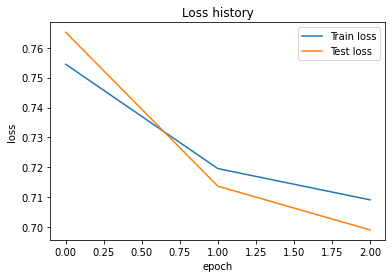

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
gpt_model.trainable = True
gpt_model.summary()

Model: "tfgp_t2lm_head_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-6))
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model_1 (TFGP TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 124,292,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=30, batch_size=64)

Epoch 1/30
85/85 [==============================] - 110s 1s/step - loss: 0.6794 - val_loss: 0.6810
Epoch 2/30
85/85 [==============================] - 94s 1s/step - loss: 0.6774 - val_loss: 0.6780
Epoch 3/30
85/85 [==============================] - 94s 1s/step - loss: 0.6732 - val_loss: 0.6741
Epoch 4/30
85/85 [==============================] - 94s 1s/step - loss: 0.6714 - val_loss: 0.6750
Epoch 5/30
85/85 [==============================] - 94s 1s/step - loss: 0.6643 - val_loss: 0.6686
Epoch 6/30
85/85 [==============================] - 94s 1s/step - loss: 0.6617 - val_loss: 0.6672
Epoch 7/30
85/85 [==============================] - 94s 1s/step - loss: 0.6565 - val_loss: 0.6608
Epoch 8/30
85/85 [==============================] - 94s 1s/step - loss: 0.6542 - val_loss: 0.6546
Epoch 9/30
85/85 [==============================] - 94s 1s/step - loss: 0.6493 - val_loss: 0.6494
Epoch 10/30
85/85 [==============================] - 94s 1s/step - loss: 0.6422 - val_loss: 0.6432
Epoch 11/30
85/85 

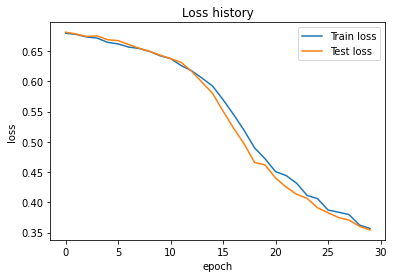

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [ ]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


Accuracy = 84.68 %


In [ ]:
pred

array([[0.9071008 ],
       [0.23182018],
       [0.954733  ],
       ...,
       [0.9575925 ],
       [0.07641407],
       [0.03949885]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬
# 정확도
print("accuracy:", accuracy_score(y_test, y_pred))

# 정밀도
print("precision:", precision_score(y_test, y_pred))

# 재현율
print("recall:", recall_score(y_test, y_pred))

# f1-score
print("F1-Score:", f1_score(y_test, y_pred))

accuracy: 0.846780162842339
precision: 0.8240997229916898
recall: 0.8814814814814815
F1-Score: 0.8518253400143164


In [ ]:
# 새로운 문장으로 테스트

new_test = pd.read_csv('./new_idiom_dataset(100).csv')

new_test['ko'][10]
new_test = new_test.sample(frac=1).reset_index(drop=True)
new_test
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)
new_test_text, _ = build_data(new_test['ko'], np.zeros(len(new_test)))
answer = new_test.Label.to_list()
len(answer)
# 시험 데이터로 학습 성능을 평가한다
new_pred = model.predict(new_test_text)
new_y_pred = np.where(new_pred > 0.5, 1, 0)
new_accuracy = (new_y_pred == answer).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


Accuracy = 84.68 %


In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬

# 정확도
print("accuracy:", accuracy_score(answer, new_y_pred))

# 정밀도
print("precision:", precision_score(answer, new_y_pred))

# 재현율
print("recall:", recall_score(answer, new_y_pred))

# f1-score
print("F1-Score:", f1_score(answer, new_y_pred))

accuracy: 0.88
precision: 0.8392857142857143
recall: 0.94
F1-Score: 0.8867924528301886
